<div class="alert alert-info" role="alert">
    <h1 style="color:black; font-size:250%; text-align:center" >Análisis de Ventas. Distribuidor Equipo de Montaña<a class='tocSkip'a> </h1>
</div>

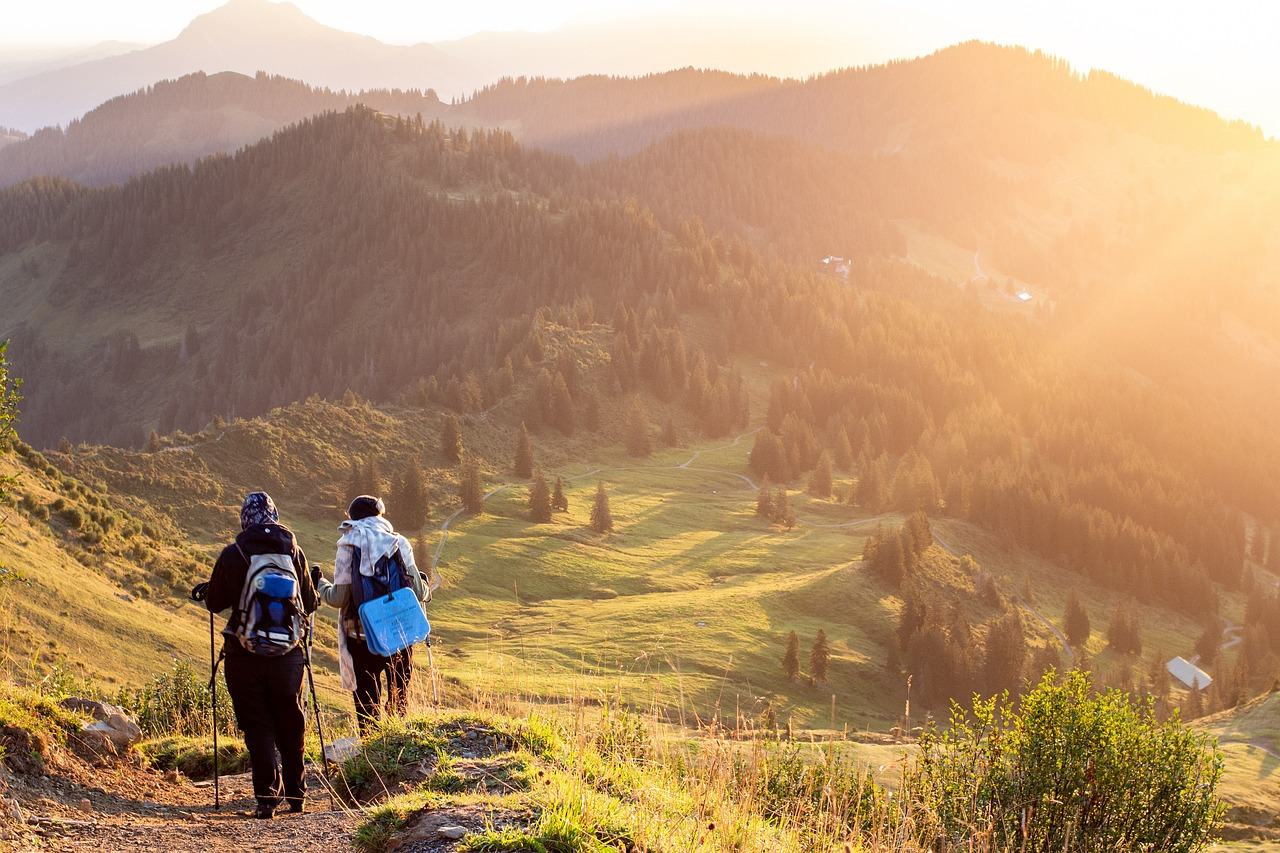

# Introducción <a class="tocSkip">

Este trabajo es la continuación del trabajo iniciado tiempo atrás donde el objetivo sigue siendo el practicar y demostrar habilidades en la programación del lenguaje **SQL**.

Por lo tanto, a continuación, se harán algunas consultas para analizar la información de una empresa ficticia denominada *Extreme Sports House*, distribuidor líder en equipo de montaña, senderismo y aventura.

<div class=text-justify>
Para este proyecto, se trabajará con MySQL que es una de las herramientas más populares en los entornos empresariales debido a que es open source y, al igual que en el trabajo previo, también se utilizará Python con un notebook de Jupiter, para poder mostrar los resultados de las consultas y, sobretodo, poder publicar este cuaderno en la web.
<div/>

En esta ocasión, el objetivo principal es hacer una **segmentación de clientes (tiendas)**, con el propósito de identificar quienes son los mejores clientes y los que están comprando mucho pero facturando poco.

# set up <a class="tocSkip">

In [1]:
import pandas as pd
import pymysql
import pymysql.cursors
import credenciales as cds

pd.options.display.float_format = '{:.2f}'.format

# Diagrama ER <a class="tocSkip">

Con el propósito de facilitar las relaciones entre las tablas, a continuación, se muestra la imagen del modelo de la base de datos a trabajar:

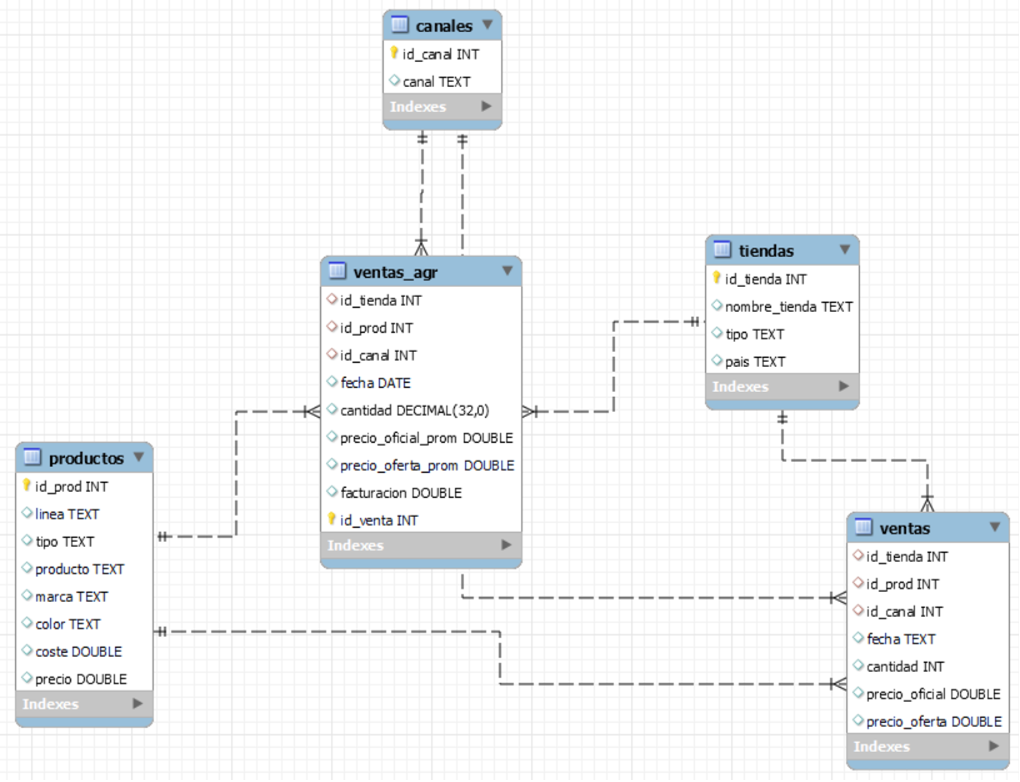

# Conexion a la base de datos <a class="tocSkip">

Primero, es necesario establecer la conexion con MySQL. Estaré usando mi equipo como servidor, por lo que, el host será local:

In [2]:
conexion = pymysql.connect(host = "localhost", 
                           user = cds.user, 
                           passwd = cds.passwd, 
                           database = "caso")

cursor = conexion.cursor()

Ya que se estableció la conexión a la base de datos con la que se trabajará, ahora se mostrarán las tablas que contiene  dicha base de datos:

In [3]:
tablas = "SHOW TABLES;"

In [4]:
cursor.execute(tablas)
filas = cursor.fetchall()

print("Tablas de la base 'caso':\n")

for fila in filas:
   print(fila)

conexion.close()

Tablas de la base 'caso':

('canales',)
('productos',)
('recomendador',)
('sistema_recomendador',)
('tiendas',)
('v_matriz_segmentacion',)
('v_ventas_agr_pedido',)
('ventas',)
('ventas_agr',)


<div class=text-justify>
Para trabajar más comodamente se crea una función, en python, para la ejecución de las consultas, ya que de esa manera, solamente se tendrá que trabajar en la consulta sin la necesidad de tener que repetir las credenciales para establecer la conexion. Además, al final la salida de las consultas será un dataframe de pandas para facilitar la visualización del resultado, ya que la salida del query es una lista de tuplas, lo cual no es tan amigable de leer.
</div>

In [5]:
def query(DB, consulta):
    
    con = pymysql.connect(
            host = 'localhost',
            user = cds.user,
            password = cds.passwd,
            db = DB,
            cursorclass = pymysql.cursors.DictCursor)

    try:

        with con.cursor() as cur:

            cur.execute(consulta)

            rows = cur.fetchall()
            desc = cur.description

            df_mysql = pd.DataFrame.from_dict(rows, orient = 'columns')

    finally:

        con.close()

    return df_mysql

La primer consulta es para conocer la tabla principal *ventas_agr:*

In [6]:
consulta = "SELECT * FROM ventas_agr;"

In [7]:
query('caso', consulta)

,id_tienda,id_prod,id_canal,fecha,cantidad,precio_oficial_prom,precio_oferta_prom,facturacion,id_venta
0,1201,109110,4,2015-01-12,648,76.86,71.48,46319.04,1
1,1201,112110,4,2015-01-12,799,10.64,10.21,8157.79,2
2,1201,115110,4,2015-01-12,755,10.71,10.28,7761.40,3
3,1205,70240,3,2015-01-12,70,122.70,114.11,7987.70,4
4,1205,71110,3,2015-01-12,28,95.62,92.75,2597.00,5
...,...,...,...,...,...,...,...,...,...
134683,1258,52110,5,2018-07-09,1011,38.00,36.48,36881.28,134684
134684,1258,53110,5,2018-07-09,476,39.99,25.99,12371.24,134685
134685,1258,54110,5,2018-07-09,476,52.99,52.99,25223.24,134686
134686,1258,55110,5,2018-07-09,476,8.00,8.00,3808.00,134687


Todo funciona bien, por lo que, de aquí en adelante se harán consultas más complejas.

 # Segmentación de clientes <a class="tocSkip">

# Crea una matriz de 4 segmentos en base al número de pedidos y la facturación de cada cliente

1. Arreglar la vista hecha previamente para dejarla a nivel de pedido, contar el número de pedidos y sumar la facturación. Agrupar por id_tienda.
2. Crear una primer tabla temporal (CTE), que contenga la consulta anterior.
3. Elaborar una segunda tabla temporal, para poder calcular la media del número de pedidos y de la facturación por tienda con la información de la primer CTE.
4. Crear la variable de segmentación en base a las medias creadas en la segunda tabla temporal. Van a ser 4 casuísticas:

 * pedidos debajo de la media y facturación debajo de la media (P- F-).
 * pedidos debajo de la media y facturación arriba de la media (P- F+).
 * pedidos arriba de la media y facturación debajo de la media (P+ F-).
 * pedidos arriba de la media y facturación arriba de la media (P+ F+).

In [8]:
consulta = "create view v_segmentacion_matriz_clientes as \
    with pedidos_fact_tienda as ( \
        select id_tienda, count(id_tienda) as num_pedidos, sum(facturacion) as facturacion \
        from v_ventas_agr_pedido \
        group by id_tienda), \
        medias as ( \
        select avg(num_pedidos) as media_pedidos, avg(facturacion) as media_facturacion \
        from pedidos_fact_tienda) \
    select *, \
        case \
            when num_pedidos <= media_pedidos and facturacion <= media_facturacion then 'P- F-' \
            when num_pedidos <= media_pedidos and facturacion > media_facturacion then 'P- F+' \
            when num_pedidos > media_pedidos and facturacion <= media_facturacion then 'P+ F-' \
            when num_pedidos > media_pedidos and facturacion > media_facturacion then 'P+ F+' \
            else 'ERROR' \
        end as segmentacion \
    from pedidos_fact_tienda, medias;"

In [9]:
query('caso', consulta)

""


In [10]:
consulta = "select * from v_segmentacion_matriz_clientes;"

In [11]:
query('caso', consulta)

,id_tienda,num_pedidos,facturacion,media_pedidos,media_facturacion,segmentacion
0,1201,2117,28624421.80,466.0484,4329978.42,P+ F+
1,1205,1544,7089471.53,466.0484,4329978.42,P+ F+
2,1215,507,21587086.56,466.0484,4329978.42,P+ F+
3,1209,967,3231567.68,466.0484,4329978.42,P+ F-
4,1216,1750,7285332.56,466.0484,4329978.42,P+ F+
...,...,...,...,...,...,...
284,1606,22,36065.89,466.0484,4329978.42,P- F-
285,1492,36,30449.84,466.0484,4329978.42,P- F-
286,1538,41,2828572.89,466.0484,4329978.42,P- F-
287,1540,18,33316.15,466.0484,4329978.42,P- F-


# ¿Cuantos clientes hay en cada segmento de la matriz?

In [12]:
consulta = "select segmentacion, count(*) as num_clientes \
            from v_segmentacion_matriz_clientes \
            group by segmentacion;"

In [13]:
query('caso', consulta)

,segmentacion,num_clientes
0,P+ F+,56
1,P+ F-,11
2,P- F+,9
3,P- F-,213


# Potencial de desarrollo <a class="tocSkip">

# Segmentar las tiendas por su tipo y calcular el percentil 75 (P75) de la facturación. Para cada tienda que esté por debajo del P75 calcular su potencial de desarrollo entendido esto como la diferencia entre la facturación del P75 y su facturación

Para dar solución a esta solicitud se procederá de la siguiente manera:

1. Preparar una tabla al nivel de tienda, o sea, agrupar por la variable id_tienda.
2. Hacer un inner join con la tabla anterior y una subconsulta en donde se acumule la facturación por tienda.
3. Crear una CTE con la consulta de los puntos anteriores, para usarla como tabla temporal principal.
4. Calcular el percentil 75 de cada una de las tiendas mediante la window function percent_rank().
5. Crear una subconsulta con la parte del código donde se creará la window function para poder filtrar los registros iguales o mayores al P75.
6. En la subconsulta anterior, crear otra columna donde este el ranking segmentado por tipo de producto.
7. Crear otra subconsulta para poder aplicar un filtro y dejar solo los primeros lugares, ya que esos serán el punto de corte.
8. El resultado anterior será la tabla objetivo donde estarán los umbrales del P75 para cada tipo de tienda, por lo que, habrá que convertirla en una tabla temporal para poder cruzarla con la primer CTE.
9. Calcular el potencial que será la diferencia entre el umbral y la facturación, mediante un CASE:

 * si P75 - facturación es menor o igual a cero entonces 0
 * si P75 - facturación es mayor a cero entonces P75 - facturación

In [14]:
consulta = "with nivel_tienda as ( \
select t.id_tienda, tipo, facturacion \
    from tiendas as t \
        inner join ( \
            select id_tienda, sum(facturacion) as facturacion \
            from ventas_agr \
            group by id_tienda) as v \
        on t.id_tienda = v.id_tienda), \
    p75_por_tienda as ( \
        select tipo, facturacion as ideal \
        from ( \
            select tipo, facturacion, percentil, row_number() over(partition by tipo order by percentil) as ranking \
            from ( \
                select *, round(percent_rank() over(partition by tipo order by facturacion),2) * 100 as percentil \
                from nivel_tienda) as con_percentil \
            where percentil >= 75) as ranking \
        where ranking = 1) \
select t.id_tienda, t.tipo, t.facturacion, ideal, \
        case \
            when (ideal - facturacion) <= 0 then 0 \
            when (ideal - facturacion) > 0 then (ideal - facturacion) \
        end as potencial \
from nivel_tienda as t \
    inner join \
     p75_por_tienda as p \
     on t.tipo = p.tipo;"

In [15]:
query('caso', consulta)

,id_tienda,tipo,facturacion,ideal,potencial
0,1115,Golf Shop,1453142.55,14071705.83,12618563.28
1,1132,Warehouse Store,5077173.20,6615904.99,1538731.79
2,1133,Outdoors Shop,6966903.78,1318208.00,0.00
3,1134,Eyewear Store,1234503.50,2867409.33,1632905.83
4,1135,Outdoors Shop,6609209.53,1318208.00,0.00
...,...,...,...,...,...
284,1760,Outdoors Shop,639065.48,1318208.00,679142.52
285,1762,Outdoors Shop,144676.00,1318208.00,1173532.00
286,1763,Sports Store,250348.00,978570.68,728222.68
287,1765,Sports Store,818929.50,978570.68,159641.18


# Reactivación de clientes <a class='tocSkip' >

# Identificar clientes que lleven más de 3 meses sin comprar (versus la última fecha disponible)

Lo anterior, se resuelve siguiendo estos pasos:

1. Obtener la fecha más reciente de la tabla ventas_agr y guardar esa consulta en una CTE.
2. Calcular la fecha máxima de cada una de las tiendas y generar otra CTE.
3. Calcular el número de días sin comprar usando las dos tablas temporales creadas y usando la función datediff().
4. Crear una subconsulta pra poder filtrar las tiendas que llevan más de 90 días sin comprar.

In [16]:
consulta = "with ultima_fecha_total as ( \
                    select max(fecha) as ult_fecha_total \
                    from ventas_agr), \
                ultima_fecha_tienda as( \
                    select id_tienda, max(fecha) as ult_fecha_tienda \
                    from ventas_agr \
                    group by id_tienda) \
            select * \
            from ( \
                    select *, datediff(ult_fecha_total, ult_fecha_tienda) as dias_sin_comprar \
                    from ultima_fecha_tienda, ultima_fecha_total \
                 ) as dias_sin_comprar \
            where dias_sin_comprar > 90;"

In [17]:
query('caso', consulta)

,id_tienda,ult_fecha_tienda,ult_fecha_total,dias_sin_comprar
0,1317,2018-03-16,2018-07-20,126
1,1346,2018-04-09,2018-07-20,102
2,1363,2018-04-11,2018-07-20,100
3,1422,2018-04-11,2018-07-20,100
4,1433,2018-04-17,2018-07-20,94
5,1495,2018-04-11,2018-07-20,100
6,1526,2018-04-12,2018-07-20,99
7,1570,2018-03-08,2018-07-20,134
8,1611,2018-03-06,2018-07-20,136
9,1663,2018-04-10,2018-07-20,101
